# Result visualization

In [1]:
from stable_baselines3 import PPO, A2C
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json

%cd ..
from src.microgrid_env import MicrogridEnv
from src.get_data import get_test_dict
from src.params import cutin_windspeed, cutoff_windspeed

C:\Code\in5460-mex1


In [12]:
# Specify if plots should be saved to output/plots
save_plots = False

# Specify model to be loaded (check out output/logs)
save_name = "ppo_q4"

In [13]:
# Load config
with open(f"output/configs/config_{save_name}.json", 'r') as json_file:
    parameters = json.load(json_file)

locals().update(parameters)  # load config parameters as variables in python

In [14]:
# Load loss data
with open(f"output/logs/{save_name}/progress.json", 'r') as file:
    loss_data = [json.loads(line) for line in file]
loss_data_list = [{key: value for key, value in entry.items() if 'loss' in key} for entry in loss_data]
df = pd.DataFrame(loss_data_list).iloc[1:].reset_index(drop=True)

# Load training data
train_df = pd.read_csv(f"output/train_data/{save_name}.csv")

window_size = 10
reward_array = train_df.reward.to_numpy()

num_rows = -(-len(reward_array) // window_size)
padding_elements = num_rows * window_size - len(reward_array)
reward_array_padded = np.pad(reward_array, (0, padding_elements), mode='empty')
reward_array_aggr = reward_array_padded.reshape(-1, window_size)
reward_array_mean = np.mean(reward_array_aggr, axis=1)

In [15]:
# Get test data
test_dict = get_test_dict(nr_households, region, seed=123, sample_size=800)

# Define gym microgrid environment
env = MicrogridEnv(test_dict, wind=wind, wind_generator=wind_generator, alternative_cost=alternative_cost)

# Load the trained model
model = PPO.load(f"output/models/model_{save_name}")
model_random = PPO.load(f"output/models/model_{save_name}_random")

In [16]:
# Test the trained agent
test_episodes = len(test_dict["energy_demand"])

obs = env.reset()
step_info = []

for _ in range(test_episodes):
    action, _ = model.predict(obs)
    obs, reward, done, info = env.step(action)

    step_info.append(env.render())
    
step_df = pd.DataFrame.from_dict(step_info)

In [17]:
# Test the random agent
obs = env.reset()
step_info = []

for _ in range(test_episodes):
    action, _ = model_random.predict(obs)
    obs, reward, done, info = env.step(action)

    step_info.append(env.render())
    
step_df_random = pd.DataFrame.from_dict(step_info)

## Descriptives

In [18]:
print("Training time (min.)", loss_data[-1]["time/time_elapsed"]/60)

Training time (min.) 18.266666666666666


In [19]:
# Count blackouts
def count_blackouts(df):
    print("absolute:", sum(df.energy_demand > df.energy_load))
    print("relative:", sum(df.energy_demand > df.energy_load) / test_episodes)

In [20]:
count_blackouts(step_df)

absolute: 4
relative: 0.005


In [21]:
count_blackouts(step_df_random)

absolute: 213
relative: 0.26625


In [22]:
step_df.reward.describe()

count      800.000000
mean     -4360.440906
std       7362.227628
min     -91990.330556
25%      -4679.786022
50%      -1856.400268
75%      -1006.300168
max        -19.126201
Name: reward, dtype: float64

In [23]:
step_df_random.reward.describe()

count       800.000000
mean     -19218.892307
std       32627.732631
min     -223686.206641
25%      -21489.811704
50%       -7282.166114
75%       -1663.854496
max         -11.674695
Name: reward, dtype: float64

In [24]:
# 0 = production, 1 = battery, 2 = sell
step_df

,reward,operational_cost,purchased_energy_cost,purchased_energy_battery,purchased_energy_load,sell_back_revenue,energy_demand,energy_load,discharged,purchase_energy,...,solar,energy_generated_wind,wind,energy_generated_generator,generator,actions_adjusting_status,soc,solar_irradiance,wind_speed,energy_price_utility_grid
0,-16854.026001,330.026001,16524.000000,270.0,0.000000,0.0,163.845203,600.162783,0,"{'load': 1, 'battery': 1}",...,0,0.000000,0,600,0,"{'solar': 1, 'wind': 0, 'generator': 1}",285.0,0.581369,28.085350,0.9
1,-19600.089548,331.040550,19269.048999,0.0,147.400709,0.0,159.601074,159.601074,0,"{'load': 1, 'battery': 1}",...,1,12.200366,0,600,1,"{'solar': 0, 'wind': 1, 'generator': 1}",285.0,991.017515,15.222284,3.5
2,-3636.292861,333.027318,3303.265543,0.0,147.400709,0.0,82.401231,620.182122,0,"{'load': 1, 'battery': 1}",...,0,0.000000,0,600,0,"{'solar': 1, 'wind': 1, 'generator': 1}",285.0,72.079008,2.706657,0.6
3,-3633.273922,330.008379,3303.265543,0.0,147.400709,0.0,123.899910,600.055862,0,"{'load': 1, 'battery': 0}",...,0,0.000000,0,600,0,"{'solar': 1, 'wind': 0, 'generator': 1}",285.0,0.199507,14.096728,0.6
4,-3633.265543,330.000000,3303.265543,0.0,147.400709,0.0,103.252434,600.000000,0,"{'load': 1, 'battery': 0}",...,0,0.000000,1,600,0,"{'solar': 1, 'wind': 0, 'generator': 1}",285.0,0.000000,27.212394,0.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,-2938.792248,361.628137,2577.164111,0.0,130.080487,0.0,99.501339,813.000636,0,"{'load': 1, 'battery': 1}",...,0,4.953214,0,600,0,"{'solar': 1, 'wind': 1, 'generator': 1}",285.0,743.026508,12.595399,0.6
796,-4757.995322,331.656825,4426.338496,0.0,139.262666,0.0,150.284711,150.284711,0,"{'load': 1, 'battery': 1}",...,0,0.000000,0,600,1,"{'solar': 1, 'wind': 0, 'generator': 1}",285.0,39.364446,48.328428,0.9
797,-2967.198517,16.306186,2950.892331,0.0,139.262666,0.0,80.773610,108.707905,0,"{'load': 1, 'battery': 0}",...,0,0.000000,1,0,0,"{'solar': 1, 'wind': 1, 'generator': 0}",285.0,388.242520,16.263511,0.6
798,-9707.048582,362.556201,9344.492381,0.0,139.262666,0.0,160.263257,600.000000,0,"{'load': 1, 'battery': 1}",...,1,0.000000,0,600,0,"{'solar': 1, 'wind': 0, 'generator': 1}",285.0,775.117334,27.911136,1.9


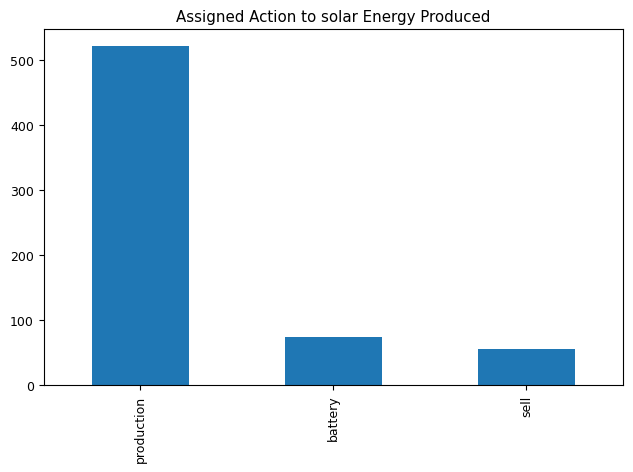

In [25]:
var = "solar"
plt.rcParams["figure.figsize"] = (6.4, 4.8)
plt.rcParams['font.size'] = 9
solar_actions = step_df[step_df[f'energy_generated_{var}'] > 0]
solar_actions = solar_actions[var].value_counts().sort_index()
solar_actions.index = ["production", "battery", "sell"]
solar_actions.plot(kind="bar")
plt.title(f"Assigned Action to {var} Energy Produced")
plt.tight_layout()
# plt.savefig(f'output/plots/DETAIL_SOLAR_{save_name}.png')
# print("Plot saved!")
plt.show()

## Training plots

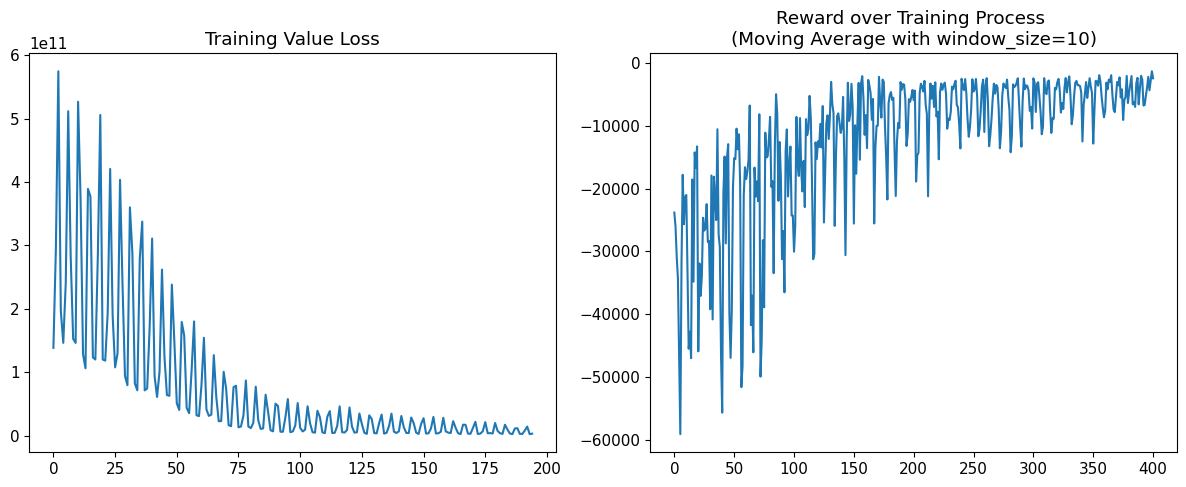

In [26]:
plt.rcParams['font.size'] = 11
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot train loss
axes[0].plot(df[df.columns[2]])
axes[0].set_title("Training Value Loss")

# Plot mean reward
axes[1].plot(reward_array_mean[:-1])
axes[1].set_title(f"Reward over Training Process \n(Moving Average with {window_size=})")

# Adjust layout to prevent clipping of titles
plt.tight_layout()

# Save
if save_plots:
    plt.savefig(f'output/plots/training_{save_name}.png')
    print("Plot saved!")

# Show the plot
plt.show()

## Test plots

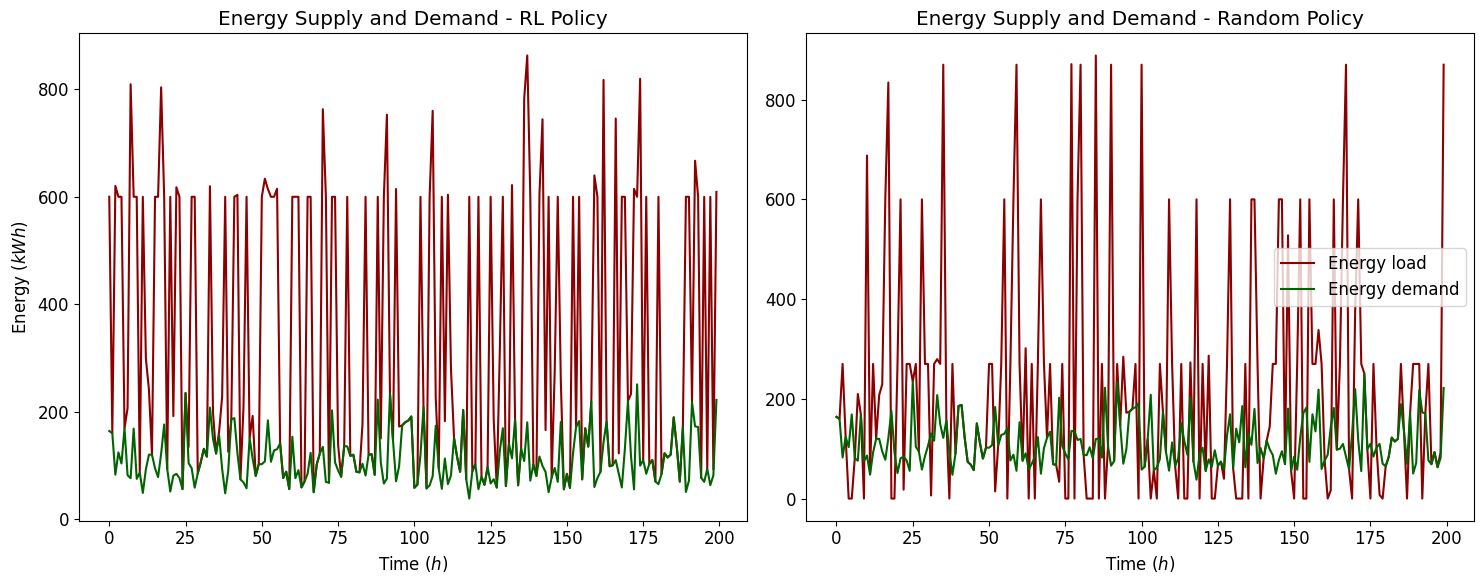

In [27]:
# Plot demand and load
k = 200

plt.rcParams["figure.figsize"] = (15,6)
plt.rcParams['font.size'] = 12
# Plotting energy demand and load for step_df
plt.subplot(1, 2, 1)
plt.plot(step_df['energy_load'][:k], color='darkred', label='Energy load')
plt.plot(step_df['energy_demand'][:k], color='darkgreen', label='Energy demand')
plt.xlabel('Time ($h$)')
plt.ylabel('Energy ($kWh$)')
plt.title('Energy Supply and Demand - RL Policy')
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Plotting energy demand and load for step_df_random
plt.subplot(1, 2, 2)
plt.plot(step_df_random['energy_load'][:k], color='darkred', label='Energy load')
plt.plot(step_df_random['energy_demand'][:k], color='darkgreen', label='Energy demand')
plt.xlabel('Time ($h$)')
#plt.ylabel('Energy (kWh)')
plt.title('Energy Supply and Demand - Random Policy')
plt.legend()#loc='center left', bbox_to_anchor=(1.05, 0.5))

# Adjust layout to prevent clipping of titles
plt.tight_layout()

# Save
if save_plots:
    plt.savefig(f'output/plots/demand_load_{save_name}.png')
    print("Plot saved!")

# Show the plot
plt.show()

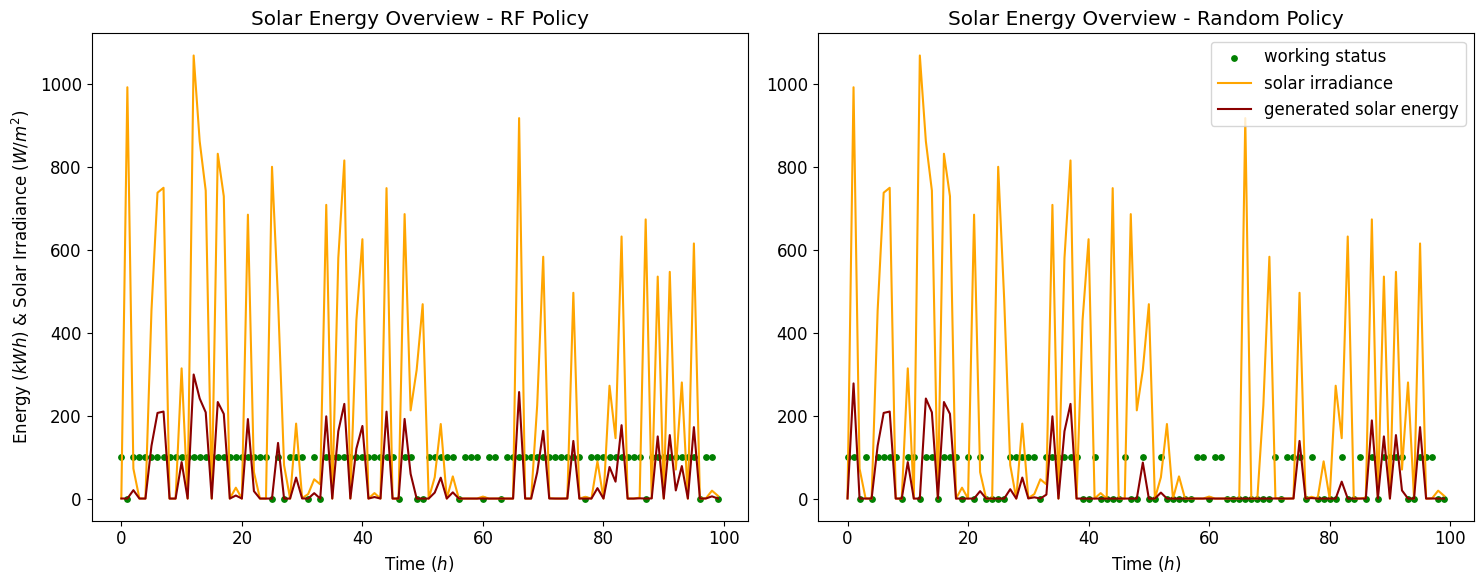

In [28]:
# Plotting solar
k = 100

plt.rcParams["figure.figsize"] = (15,6)
plt.rcParams['font.size'] = 12
# Plotting solar for step_df
plt.subplot(1, 2, 1)
working_status = [d.get("solar") for d in step_df['actions_adjusting_status']]
working_status = [v * 100 for v in working_status]
plt.scatter(range(k), working_status[:k], color='green', label='working status', alpha=1, s=15)
plt.plot(step_df['solar_irradiance'][:k], color='orange', label='solar irradiance', alpha=1)
plt.plot(step_df['energy_generated_solar'][:k], color='darkred', label='generated solar energy', alpha=1)
plt.xlabel('Time ($h$)')
plt.ylabel('Energy ($kWh$) & Solar Irradiance ($W/m^2$)')
plt.title('Solar Energy Overview - RF Policy')
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Plotting solar for step_df_random
plt.subplot(1, 2, 2)
working_status_random = [d.get("solar") for d in step_df_random['actions_adjusting_status']]
working_status_random = [v * 100 for v in working_status_random]
plt.scatter(range(k), working_status_random[:k], color='green', label='working status', alpha=1, s=15)
plt.plot(step_df_random['solar_irradiance'][:k], color='orange', label='solar irradiance', alpha=1)
plt.plot(step_df_random['energy_generated_solar'][:k], color='darkred', label='generated solar energy', alpha=1)
plt.xlabel('Time ($h$)')
#plt.ylabel('Energy ($kWh$) & Solar Irradiance ($W/m^2$)')
plt.title('Solar Energy Overview - Random Policy')
plt.legend()#loc='center left', bbox_to_anchor=(1, 0.5))

# Adjust layout to prevent clipping of titles
plt.tight_layout()

# Save
if save_plots:
    plt.savefig(f'output/plots/solar_overview_{save_name}.png')
    print("Plot saved!")

# Show the plot
plt.show()

In [29]:
sum([1 for i in step_df_random.actions_adjusting_status if i["solar"] == 1])

404

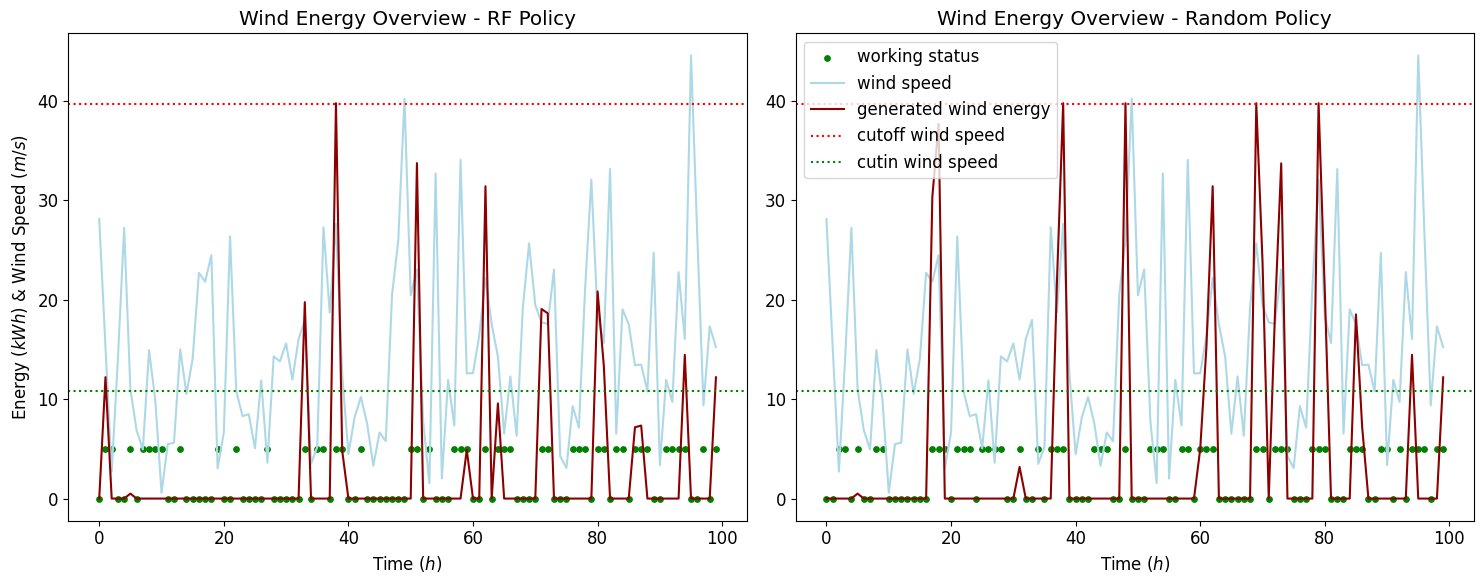

In [30]:
# Plotting wind
k = 100

plt.rcParams["figure.figsize"] = (15,6)
plt.rcParams['font.size'] = 12
# Plotting wind for step_df
plt.subplot(1, 2, 1)
working_status = [d.get("wind") for d in step_df['actions_adjusting_status']]
working_status = [v * 5 for v in working_status]
plt.scatter(range(k), working_status[:k], color='green', label='working status', alpha=1, s=15)
plt.plot(step_df['wind_speed'][:k], color='lightblue', label='wind speed', alpha=1)
plt.plot(step_df['energy_generated_wind'][:k], color='darkred', label='generated wind energy', alpha=1)
plt.axhline(y=cutoff_windspeed, color='red', linestyle='dotted', label='cutoff wind speed')
plt.axhline(y=cutin_windspeed, color='green', linestyle='dotted', label='cutin wind speed')
plt.xlabel('Time ($h$)')
plt.ylabel('Energy ($kWh$) & Wind Speed ($m/s$)')
plt.title('Wind Energy Overview - RF Policy')
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Plotting wind for step_df_random
plt.subplot(1, 2, 2)
working_status_random = [d.get("wind") for d in step_df_random['actions_adjusting_status']]
working_status_random = [v * 5 for v in working_status_random]
plt.scatter(range(k), working_status_random[:k], color='green', label='working status', alpha=1, s=15)
plt.plot(step_df_random['wind_speed'][:k], color='lightblue', label='wind speed', alpha=1)
plt.plot(step_df_random['energy_generated_wind'][:k], color='darkred', label='generated wind energy', alpha=1)
plt.axhline(y=cutoff_windspeed, color='red', linestyle='dotted', label='cutoff wind speed')
plt.axhline(y=cutin_windspeed, color='green', linestyle='dotted', label='cutin wind speed')
plt.xlabel('Time ($h$)')
#plt.ylabel('Energy ($kWh$) & Wind Speed ($m/s$)')
plt.title('Wind Energy Overview - Random Policy')
plt.legend()#loc='center left', bbox_to_anchor=(1, 0.5))

# Adjust layout to prevent clipping of titles
plt.tight_layout()

# Save
if save_plots and (wind or wind_generator):
    plt.savefig(f'output/plots/wind_overview_{save_name}.png')
    print("Plot saved!")

# Show the plot
plt.show()

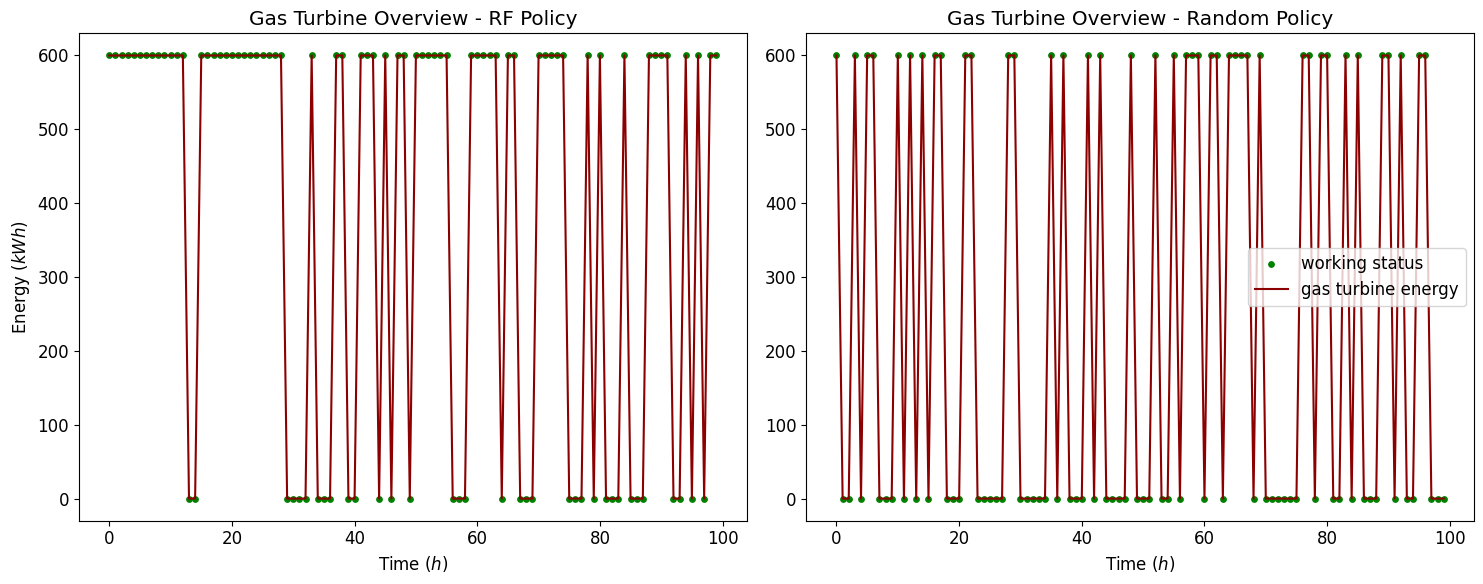

In [31]:
# Plotting generator
k = 100

plt.rcParams["figure.figsize"] = (15,6)
plt.rcParams['font.size'] = 12
# Plotting gas turbine for step_df
plt.subplot(1, 2, 1)
working_status = [d.get("generator") for d in step_df['actions_adjusting_status']]
working_status = [v * 600 for v in working_status]
plt.scatter(range(k), working_status[:k], color='green', label='working status', alpha=1, s=15)
plt.plot(step_df['energy_generated_generator'][:k], color='darkred', label='gas turbine energy', alpha=1)
plt.xlabel('Time ($h$)')
plt.ylabel('Energy ($kWh$)')
plt.title('Gas Turbine Overview - RF Policy')
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Plotting gas turbine for step_df_random
plt.subplot(1, 2, 2)
working_status_random = [d.get("generator") for d in step_df_random['actions_adjusting_status']]
working_status_random = [v * 600 for v in working_status_random]
plt.scatter(range(k), working_status_random[:k], color='green', label='working status', alpha=1, s=15)
plt.plot(step_df_random['energy_generated_generator'][:k], color='darkred', label='gas turbine energy', alpha=1)
plt.xlabel('Time ($h$)')
#plt.ylabel('Energy ($kWh$)')
plt.title('Gas Turbine Overview - Random Policy')
plt.legend()#loc='center left', bbox_to_anchor=(1, 0.5))

# Adjust layout to prevent clipping of titles
plt.tight_layout()

# Save
if save_plots and wind_generator:
    plt.savefig(f'output/plots/generator_overview_{save_name}.png')
    print("Plot saved!")

# Show the plot
plt.show()